In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

# extract images from label directories into training and test sets
def extract_label_images(path,label,training_images,training_labels,train_value,test_images,test_labels,test_value):
    new_path = path + "/" +label
    train_count = 0
    test_count = 0
    
    ## resize images to 128x128 grayscale 
    for file in os.listdir(new_path):
    # grab only 10 images from label directory for testing purposes 
        if (train_count < train_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(new_path+ "/" +file)), cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(128,128))
            training_images.append(img)
            training_labels.append(label)
            train_count = train_count + 1 
            
        elif (test_count < test_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(new_path+ "/" +file)), cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(128,128))
            test_images.append(img)
            test_labels.append(label)
            test_count = test_count + 1 
        else:
            break
            
    print("FINISH EXTRACTING LABEL : ", label)
                
    return training_images,test_images


In [2]:
def extractLabels(path):
    label_list = []
    for file in os.listdir(path):
        label_list.append(""+file)
    return label_list


In [3]:
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures


In [4]:
training_set_path= r"./MIO-TCD-Classification/train"
labels = extractLabels(training_set_path)
train_images = []
train_labels = []
train_value = 1500

test_images = []
test_labels = []
test_value = 1

## Extracting 128x128 gray scale images from each label directory

for label in labels:
    extract_label_images(training_set_path, label, train_images, train_labels, train_value, test_images, test_labels, test_value)

print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))


FINISH EXTRACTING LABEL :  articulated_truck
FINISH EXTRACTING LABEL :  background
FINISH EXTRACTING LABEL :  bicycle
FINISH EXTRACTING LABEL :  bus
FINISH EXTRACTING LABEL :  car
FINISH EXTRACTING LABEL :  motorcycle
FINISH EXTRACTING LABEL :  non-motorized_vehicle
FINISH EXTRACTING LABEL :  pedestrian
FINISH EXTRACTING LABEL :  pickup_truck
FINISH EXTRACTING LABEL :  single_unit_truck
FINISH EXTRACTING LABEL :  work_van
16500
16500
11
11


In [5]:
## extract hog features of each images of labels 
training_img_features = getHogFeatures(train_images)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
#model.fit(training_img_features, train_labels)

In [7]:
# prediction_data = getHogFeatures(test_images)
# result = model.predict(prediction_data)

In [8]:
#print(result)
#print(test_labels)

from sklearn.utils import shuffle

training_img_features = shuffle(training_img_features, random_state=0)
train_labels = shuffle(train_labels, random_state=0)


#### Cross validation

In [9]:
def classifierAccuracy(predictions, answers):
    total_predictions = len(predictions)
    correct_predictions = 0
    for p, a in zip(predictions, answers):
        if (p == a):
            correct_predictions = correct_predictions + 1 
            
    print("CORRECT predictions : ", correct_predictions)
    print("TOTAL PREDICTIONS : ", total_predictions)
    print("ACCURACY ", (correct_predictions/total_predictions))
  
    return (correct_predictions/total_predictions)
            

In [10]:
from sklearn.model_selection import KFold

# The .split() method returns indices to the dataset
kf_splitter = KFold(n_splits=10)
## In each loop, train our regressor and save the MSE

train_label_prediction_accuracy = []
valid_label_prediction_accuracy = []
## NOTE: We can use cross_val_score instead of this loop

training_img_features = np.array(training_img_features)
train_labels = np.array(train_labels)
#print(len(train_labels))

for train_index, valid_index in kf_splitter.split(training_img_features):

    train_set = training_img_features[train_index, :]
    t_label = train_labels[train_index]
    
    # Get our validation data in this fold
    valid_set = training_img_features[valid_index, :]
    v_label = train_labels[valid_index]
    
    # Train KNN Classfier
    model.fit(train_set, t_label)
    
    # Get our prediction for training, validation:
    prediction_train = model.predict(train_set)
    prediction_valid = model.predict(valid_set)
    
    train_label_prediction_accuracy.append(classifierAccuracy(prediction_train, t_label))
    valid_label_prediction_accuracy.append(classifierAccuracy(prediction_valid, v_label))

# Print the mse
print(train_label_prediction_accuracy)
print(valid_label_prediction_accuracy)


CORRECT predictions :  12567
TOTAL PREDICTIONS :  14850
ACCURACY  0.8462626262626263
CORRECT predictions :  1187
TOTAL PREDICTIONS :  1650
ACCURACY  0.7193939393939394
CORRECT predictions :  12568
TOTAL PREDICTIONS :  14850
ACCURACY  0.8463299663299664
CORRECT predictions :  1203
TOTAL PREDICTIONS :  1650
ACCURACY  0.7290909090909091
CORRECT predictions :  12553
TOTAL PREDICTIONS :  14850
ACCURACY  0.8453198653198654
CORRECT predictions :  1180
TOTAL PREDICTIONS :  1650
ACCURACY  0.7151515151515152
CORRECT predictions :  12566
TOTAL PREDICTIONS :  14850
ACCURACY  0.8461952861952862
CORRECT predictions :  1183
TOTAL PREDICTIONS :  1650
ACCURACY  0.7169696969696969
CORRECT predictions :  12581
TOTAL PREDICTIONS :  14850
ACCURACY  0.8472053872053872
CORRECT predictions :  1186
TOTAL PREDICTIONS :  1650
ACCURACY  0.7187878787878788
CORRECT predictions :  12520
TOTAL PREDICTIONS :  14850
ACCURACY  0.8430976430976431
CORRECT predictions :  1196
TOTAL PREDICTIONS :  1650
ACCURACY  0.724848484

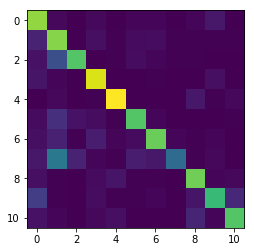

In [11]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix( v_label, prediction_valid)

plt.figure()
plt.imshow(conf)

In [ ]:
## SAVING MODEL

from sklearn.externals import joblib
joblib.dump(model, 'filename.pk1')

# # load back the pickled model at a later time
# clf = joblib.load('filename.pk1')